#### Import Python Models

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from tqdm import tqdm
from tool_box.utils import NMSE
# fix random seed


plt.rcParams['figure.dpi'] = 300

#### Console

In [2]:
np.random.seed(3)
N_RF = 1000
SNR = 50 # dB

### Hide Part 1

#### Read Generated Channel Data

In [3]:
# read data from \generate_channel_data\generate_channel_data.mat
import scipy.io as sio
generate_channel_data = sio.loadmat('./data/generate_channel_data.mat')
cluster_para = generate_channel_data['meta_data']['cluster_para']
# xi = generate_channel_data['meta_data']['xi']
f_c = generate_channel_data['meta_data']['f_c']
N_x = int(generate_channel_data['meta_data']['N_x'])
N_y = int(generate_channel_data['meta_data']['N_y'])
lambda_c = generate_channel_data['meta_data']['lambda_c']
delta = generate_channel_data['meta_data']['delta']
N = int(generate_channel_data['meta_data']['N'])
L_x = generate_channel_data['meta_data']['L_x']
L_y = generate_channel_data['meta_data']['L_y']

H_channel = np.mat(generate_channel_data['channel']['H_channel'][0][0])
vec_H_a = np.mat(generate_channel_data['channel']['vec_H_a'][0][0])
variance = np.mat(generate_channel_data['channel']['variance'][0][0])
Psi = np.mat(generate_channel_data['channel']['Psi'][0][0])

K = 0
sparseness = 0.1


sparse_power_threshold = 0.9
eta = 0.15
Geo_Approx_para = {
    'epsilon_1' : 1e4,
    'epsilon_2' : 1e-3,
    'epsilon_3' : 1e3,
    'epsilon_4' : 1e-2,
    'K' : 0,   # the number of nonZero elements in the sparse vector
    'tau' : 0.1,    # the 2K largest entries of the sparse vector
    'alpha' : 5     # the biggest entry of the sparse vector
}

/var/folders/n6/9zkr6zk96qz10ctnvn_mhc840000gn/T/ipykernel_32297/4178796438.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  N_x = int(generate_channel_data['meta_data']['N_x'])
/var/folders/n6/9zkr6zk96qz10ctnvn_mhc840000gn/T/ipykernel_32297/4178796438.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  N_y = int(generate_channel_data['meta_data']['N_y'])
/var/folders/n6/9zkr6zk96qz10ctnvn_mhc840000gn/T/ipykernel_32297/4178796438.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Depr

In [4]:
xi = []
l_x_abs_max = int(L_x / lambda_c)
l_y_abs_max = int(L_y / lambda_c)
print("l_x_abs_max = ", l_x_abs_max)
print("l_y_abs_max = ", l_y_abs_max)

# for start with -l_x_abs_max to l_x_abs_max
for l_x in range(-l_x_abs_max, l_x_abs_max + 1):
    # for start with -l_y_abs_max to l_y_abs_max
    for l_y in range(-l_y_abs_max, l_y_abs_max + 1):
        k_x = 2 * np.pi * l_x / L_x
        k_y = 2 * np.pi * l_y / L_y
        if k_x ** 2 + k_y ** 2 < (2 * np.pi / lambda_c) ** 2:
            xi.append((l_x, l_y))

M = len(xi)
print("M = ", M)

l_x_abs_max =  32
l_y_abs_max =  32
M =  3205


/var/folders/n6/9zkr6zk96qz10ctnvn_mhc840000gn/T/ipykernel_32297/2578872600.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  l_x_abs_max = int(L_x / lambda_c)
/var/folders/n6/9zkr6zk96qz10ctnvn_mhc840000gn/T/ipykernel_32297/2578872600.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  l_y_abs_max = int(L_y / lambda_c)


#### Visualize Channel

/var/folders/n6/9zkr6zk96qz10ctnvn_mhc840000gn/T/ipykernel_32297/3182367393.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mat_H_a[l_x + l_x_abs_max, l_y + l_y_abs_max] = vec_H_a[l]


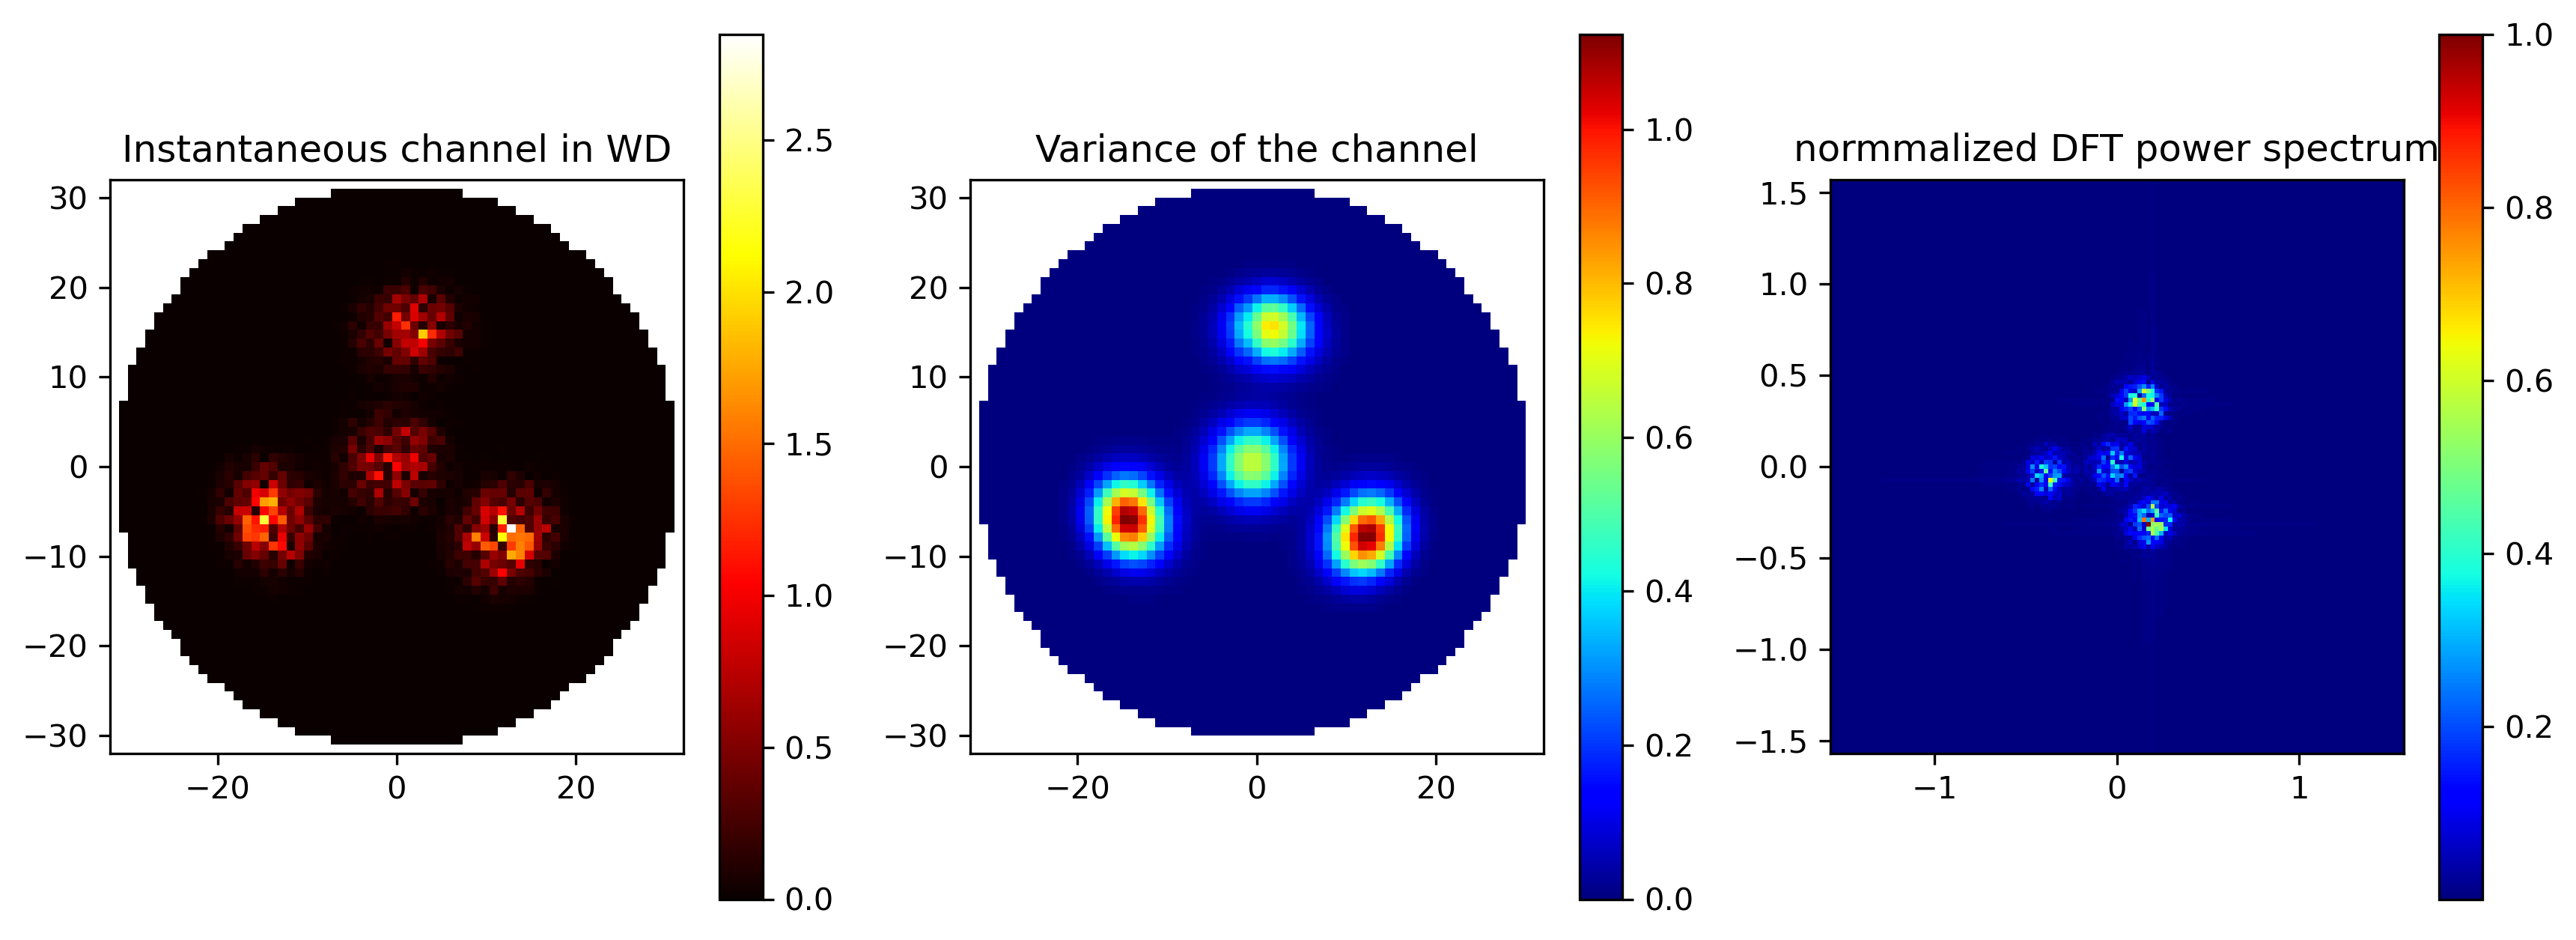

In [5]:
# visualize the channel
def visualize_wavenumber_domain_channel(vec_H_a):
    mat_H_a = np.mat(np.zeros((2*l_x_abs_max+1, 2*l_y_abs_max+1), dtype=complex))
    # all set to np.nan in mat_H_a
    mat_H_a[:,:] = np.nan
    for l, l_pair in enumerate(xi):
        l_x = l_pair[0]
        l_y = l_pair[1]
        mat_H_a[l_x + l_x_abs_max, l_y + l_y_abs_max] = vec_H_a[l]

    # plt.figure(figsize=(10, 10))
    plt.imshow(np.abs(mat_H_a), extent=[-l_x_abs_max, l_x_abs_max, -l_y_abs_max, l_y_abs_max], cmap='hot')
    plt.colorbar()
    plt.title('Instantaneous channel in WD')
    return mat_H_a
    
def visualize_wavenumber_variance(variance):
    # plt.figure(figsize=(8, 6))
    plt.imshow(variance, cmap='jet', extent=[-l_x_abs_max, l_x_abs_max, -l_y_abs_max, l_y_abs_max])
    plt.colorbar()
    plt.title('Variance of the channel')

def DFT_power_spectrum(H_channel):
    # DFT power spectrum of the channel
    DFT_power = np.abs(np.fft.fft2(np.reshape(H_channel, (N_x, N_y))))

    # element shift according to the DFT power spectrum
    DFT_power = np.fft.fftshift(DFT_power)
    
    # normalize the DFT power spectrum
    DFT_power = DFT_power / np.max(DFT_power)

    # visualize the DFT power spectrum
    # plt.figure(figsize=(10, 10))
    plt.imshow(DFT_power, cmap='jet', extent=[-np.pi/2, np.pi/2, -np.pi/2, np.pi/2])
    plt.colorbar()
    plt.title('normmalized DFT power spectrum')
    return DFT_power

plt.figure(figsize=(14, 5))
# sub out of 3 in one row
plt.subplot(131)
visualize_wavenumber_domain_channel(vec_H_a)

plt.subplot(132)
visualize_wavenumber_variance(variance)

plt.subplot(133)
mat_H_DFT = DFT_power_spectrum(H_channel)
vec_H_DFT = np.reshape(
    np.array(
        mat_H_DFT
    ), (int(mat_H_DFT.shape[0] * mat_H_DFT.shape[1]), )
)

#### Observation Model


$$
{\bf y} = {\bf C} {\bf \Psi} {\bf h}_a + {\bf n}
$$

In [6]:
# Measurement matrxi for compressed sensing, {N}_{RF} \times N
measurement_matrix = np.random.randn(N_RF, N) * 1 / np.sqrt(N)

y = np.dot(
    measurement_matrix,
    np.dot(
        Psi, vec_H_a
    )
)
Phi = np.dot(measurement_matrix, Psi)

#### Index-Wavenumber Remapping

In [7]:
def from_idx_to_l(idx):
    return (idx[0] - l_x_abs_max, idx[1] - l_y_abs_max)

def from_l_to_idx(l):
    return (l[0] + l_x_abs_max, l[1] + l_y_abs_max)

#### Graph Edge Value Calculation

$$
\eta_{l,l^\prime} = 0.5 \arcsin \left( \left( 1-m^8 \right)^{-0.25} \right)
$$

$$
m = \frac{(+1) \times \tilde{K} + (-1) \times (N-\tilde{K})}
{N}
$$

In [8]:
# Useless function
def get_eta(sparseness):
    m = 1 * sparseness + (-1) * (1 - sparseness)
    eta = 0.5 * np.arcsin(
        np.power(
            1 - np.power(m, 8), -0.25
        )
    )
    return eta
# eta = get_eta(sparseness = 0.2)

#### Graph 'Energy Function' Model

$$
\begin{aligned}
V_{l,l^\prime}\left(s_l, s_{l^\prime}\right) &= - \eta_{l,l^\prime} \cdot \left(s_l s_{l^\prime} - 1 \right) \\
&= \eta_{l,l^\prime} \cdot \left(1 - s_l s_{l^\prime} \right)
\end{aligned}
$$

In [9]:
def func_V(s_l, s_l_prime):
    return eta * (1 - s_l * s_l_prime)

$$
D_l\left( s_l \right) = -\log \left( \hat{p} \left( h^{(j-1)}_{s,l} \right) \right)
$$

In [10]:
def func_D(h_sl, s_l, Geo_Approx_para):
    tau = Geo_Approx_para['tau']
    if s_l == 1:
        if h_sl <= tau:
            epsilon_4 = Geo_Approx_para['epsilon_4']
            return np.log10(epsilon_4)
        else:
            epsilon_3 = Geo_Approx_para['epsilon_3']
            return np.log10(epsilon_3)
    elif s_l == -1:
        if h_sl <= tau:
            epsilon_1 = Geo_Approx_para['epsilon_1']
            return np.log10(epsilon_1)
        else:
            epsilon_2 = Geo_Approx_para['epsilon_2']
            return np.log10(epsilon_2)
    else:
        raise ValueError('s_l must be 1 or -1')

#### Graph init

In [11]:
myGraph = nx.grid_2d_graph(int(2*l_x_abs_max+1), int(2*l_y_abs_max+1))

# traverse graph nodes, minus the absolute max of x and y
node_set = myGraph.nodes()

for l_x in range(-l_x_abs_max, l_x_abs_max+1):
    for l_y in range(-l_y_abs_max, l_y_abs_max+1):
        node_idx = from_l_to_idx((l_x, l_y))
        
        if (l_x, l_y) not in xi:
            myGraph.remove_node(node_idx)
            continue
        else:
            myGraph.nodes[node_idx]['l'] = (l_x, l_y)
            myGraph.nodes[node_idx]['s'] = -1

# add node 'a' and 'b'
myGraph.add_node('a')   # node alpha
myGraph.add_node('b')   # node beta

# add edge between node and 'a', 'b'
for l in xi:
    node_idx = from_l_to_idx(l)
    myGraph.add_edge('a', node_idx, weight = 0)
    myGraph.add_edge('b', node_idx, weight = 0)

#### neighbor remapping

In [12]:
def neighbor_l(Graph, l):
    (l_x, l_y) = l
    node_idx = (l_x + l_x_abs_max, l_y + l_y_abs_max)
    res = []
    for nei_node_idx in Graph.neighbors(node_idx):
        if nei_node_idx == 'a' or nei_node_idx == 'b':
            continue
        else:
            res.append(Graph.nodes[nei_node_idx]['l'])
    return res
print(neighbor_l(myGraph, (0, 0)))

[(-1, 0), (1, 0), (0, -1), (0, 1)]


#### Find the non Zero enries in the Sparse Channel

In [13]:
def find_real_sparseness(vec_H_a, threshold=0.9):
    vec_H_a_abs = np.abs(vec_H_a)
    M = vec_H_a_abs.shape[0]
    # sort the vector in descending order
    vec_H_a_sorted = np.sort(np.reshape(np.array(vec_H_a_abs), (M,)), )
    vec_H_a_sorted = np.flip(vec_H_a_sorted, axis=0)
    overall_power = np.sum(vec_H_a_sorted)
    
    K = 0
    for i, val in enumerate(vec_H_a_sorted):
        if np.sum(vec_H_a_sorted[0:i]) >= threshold * overall_power:
            K = i
            break
    tau = 0
    if 2 * K >= M:
        tau = vec_H_a_sorted[-1]
    else:
        tau = vec_H_a_sorted[2 * K]
    alpha = vec_H_a_sorted[0]
    return K, tau, alpha

K, tau, alpha = find_real_sparseness(vec_H_a, threshold=sparse_power_threshold)
sparseness = K / M
print(
    "K = {}, \nN = {}, \n2K = {} \ntau = {}, \nalpha = {}, \nsparseness = {}".format(K, N, 2*K, tau, alpha, sparseness)
)
Geo_Approx_para['K'] = K
Geo_Approx_para['tau'] = tau
Geo_Approx_para['alpha'] = alpha    # alpha is the largest value in the vector

K = 415, 
N = 16641, 
2K = 830 
tau = 0.012764218095888973, 
alpha = 2.8491992098074905, 
sparseness = 0.1294851794071763


In [14]:
# print sparseness of vec_H_DFT
K_DFT, tau_DFT, alpha_DFT = find_real_sparseness(vec_H_DFT, threshold=sparse_power_threshold)
sparseness_DFT = K_DFT / len(vec_H_DFT)
print(
    "K_DFT = {}, \nN_DFT = {}, \n2K_DFT = {} \ntau_DFT = {}, \nalpha_DFT = {}, \nsparseness_DFT = {}".format(K_DFT, len(vec_H_DFT), 2*K_DFT, tau_DFT, alpha_DFT, sparseness_DFT)
)

K_DFT = 1128, 
N_DFT = 16641, 
2K_DFT = 2256 
tau_DFT = 0.0022760345976456323, 
alpha_DFT = 1.0, 
sparseness_DFT = 0.06778438795745448


#### Test Region

In [15]:
vec_H_a_abs = np.abs(vec_H_a)
N = vec_H_a_abs.shape[0]
# sort the vector in descending order
vec_H_a_sortd = np.sort(np.reshape(np.array(vec_H_a_abs), (N,)), )
vec_H_a_sortd = np.flip(vec_H_a_sortd, axis=0)
overall_power = np.sum(vec_H_a_sortd)
for i, val in enumerate(vec_H_a_sortd):
    if np.sum(vec_H_a_sortd[0:i]) >= 0.95 * overall_power:
        break


#### Graph Example

In [16]:
G = nx.Graph()
G.add_edge("x", "a", capacity=3.0)
G.add_edge("x", "b", capacity=0.5)
G.add_edge("a", "c", capacity=3.0)
G.add_edge("b", "c", capacity=5.0)
G.add_edge("b", "d", capacity=4.0)
G.add_edge("d", "e", capacity=2.0)
G.add_edge("c", "y", capacity=2.0)
G.add_edge("e", "y", capacity=3.0)

In [17]:
cut_value, partition = nx.minimum_cut(G, "x", "y")
reachable, non_reachable = partition

cutset = set()
for u, nbrs in ((n, G[n]) for n in reachable):
    cutset.update((u, v) for v in nbrs if v in non_reachable)
print(sorted(cutset))

[('a', 'c'), ('x', 'b')]


#### Test the NumPy Matrix Indexing

In [18]:
test_mat = np.array([[1,2,3],[4,5,6],[7,8,9]])
test_mat[0,0]

1

#### Test EMRF.py

In [19]:
from tool_box.EMRF import EMRF
# add noise
noise = np.random.randn(*y.shape) + 1j * np.random.randn(*y.shape)
noise = noise / np.linalg.norm(noise) * np.linalg.norm(y) / 10 ** (SNR / 20) 
y = y + noise

test_EMRF = EMRF(
    Graph = myGraph,
    y = y,
    Phi = Phi,
    vec_H_a=vec_H_a,
    xi = xi,
    l_x_abs_max=l_x_abs_max,
    l_y_abs_max=l_y_abs_max,
    Geo_Approx_para=Geo_Approx_para,
)


In [20]:
def test_visual(path = "default"):
    # subplots 1 row 2 columns
    plt.figure(figsize=(14, 5))

    # subplot 1
    plt.subplot(1, 2, 1)
    # visualize the support variable
    visualize_wavenumber_domain_channel(test_EMRF.get_support() + 1)

    # subplot 2
    plt.subplot(1, 2, 2)
    # visualize the hat_h
    visualize_wavenumber_domain_channel(test_EMRF.hat_h_sl)
    # save the figure
    if path != "default":
        plt.savefig(path)


### Show Progress bar

#### Test $\alpha-\beta$-swap

In [21]:
iter_num = 15
# use tqdm
for i in tqdm(range(iter_num)):
    test_EMRF.alpha_beta_swap()

  0%|          | 0/15 [00:00<?, ?it/s]

  7%|▋         | 1/15 [00:00<00:04,  2.98it/s]/Users/brookbupt/Documents/GitHub/ICC-GXF/code/tool_box/EMRF.py:252: RuntimeWarning: divide by zero encountered in log10
  return - np.log10(pdf)
100%|██████████| 15/15 [00:07<00:00,  2.00it/s]


NMSE =  0.01668323001538505
NMSE_v2 =  0.016532348676263516
Converge NMSE =  0.01693646280032408
Converge NMSE_v2 =  0.0167832011685664


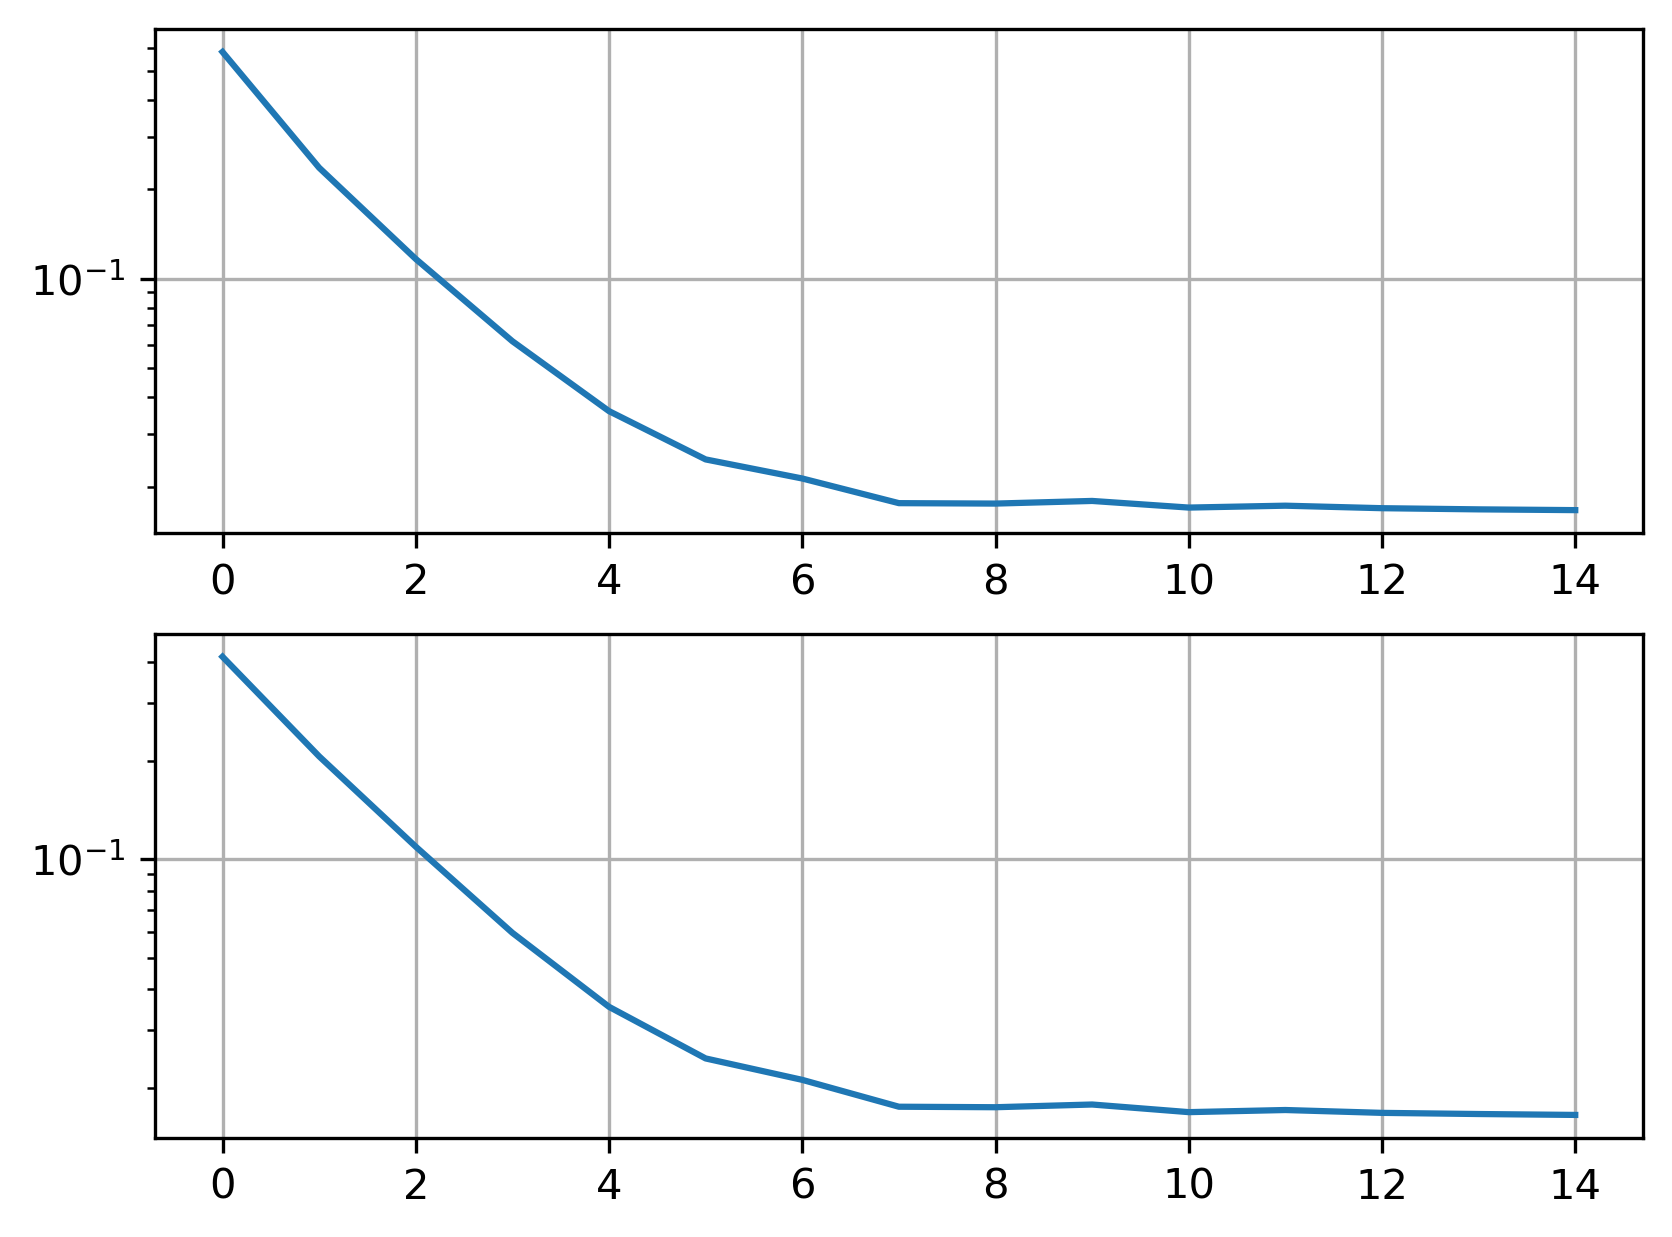

In [22]:
NMSE_list_v2 = test_EMRF.NMSE_list_v2
NMSE_list = test_EMRF.NMSE_list
# plot NMSE_list
plt.figure()
plt.subplot(211)
plt.plot(NMSE_list)
# set log scale
plt.yscale('log')
# grid on
plt.grid(True)

plt.subplot(212)
plt.plot(NMSE_list_v2)
# set log scale
plt.yscale('log')
# grid on  
plt.grid(True)

print("NMSE = ", np.min(NMSE_list))
print("NMSE_v2 = ", np.min(NMSE_list_v2))

# print the mean of the last 5 NMSE
print("Converge NMSE = ", np.mean(NMSE_list[-5:]))
print("Converge NMSE_v2 = ", np.mean(NMSE_list_v2[-5:]))

/var/folders/n6/9zkr6zk96qz10ctnvn_mhc840000gn/T/ipykernel_32297/1438936305.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  spacing = int(lambda_c / delta)
/var/folders/n6/9zkr6zk96qz10ctnvn_mhc840000gn/T/ipykernel_32297/3182367393.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mat_H_a[l_x + l_x_abs_max, l_y + l_y_abs_max] = vec_H_a[l]


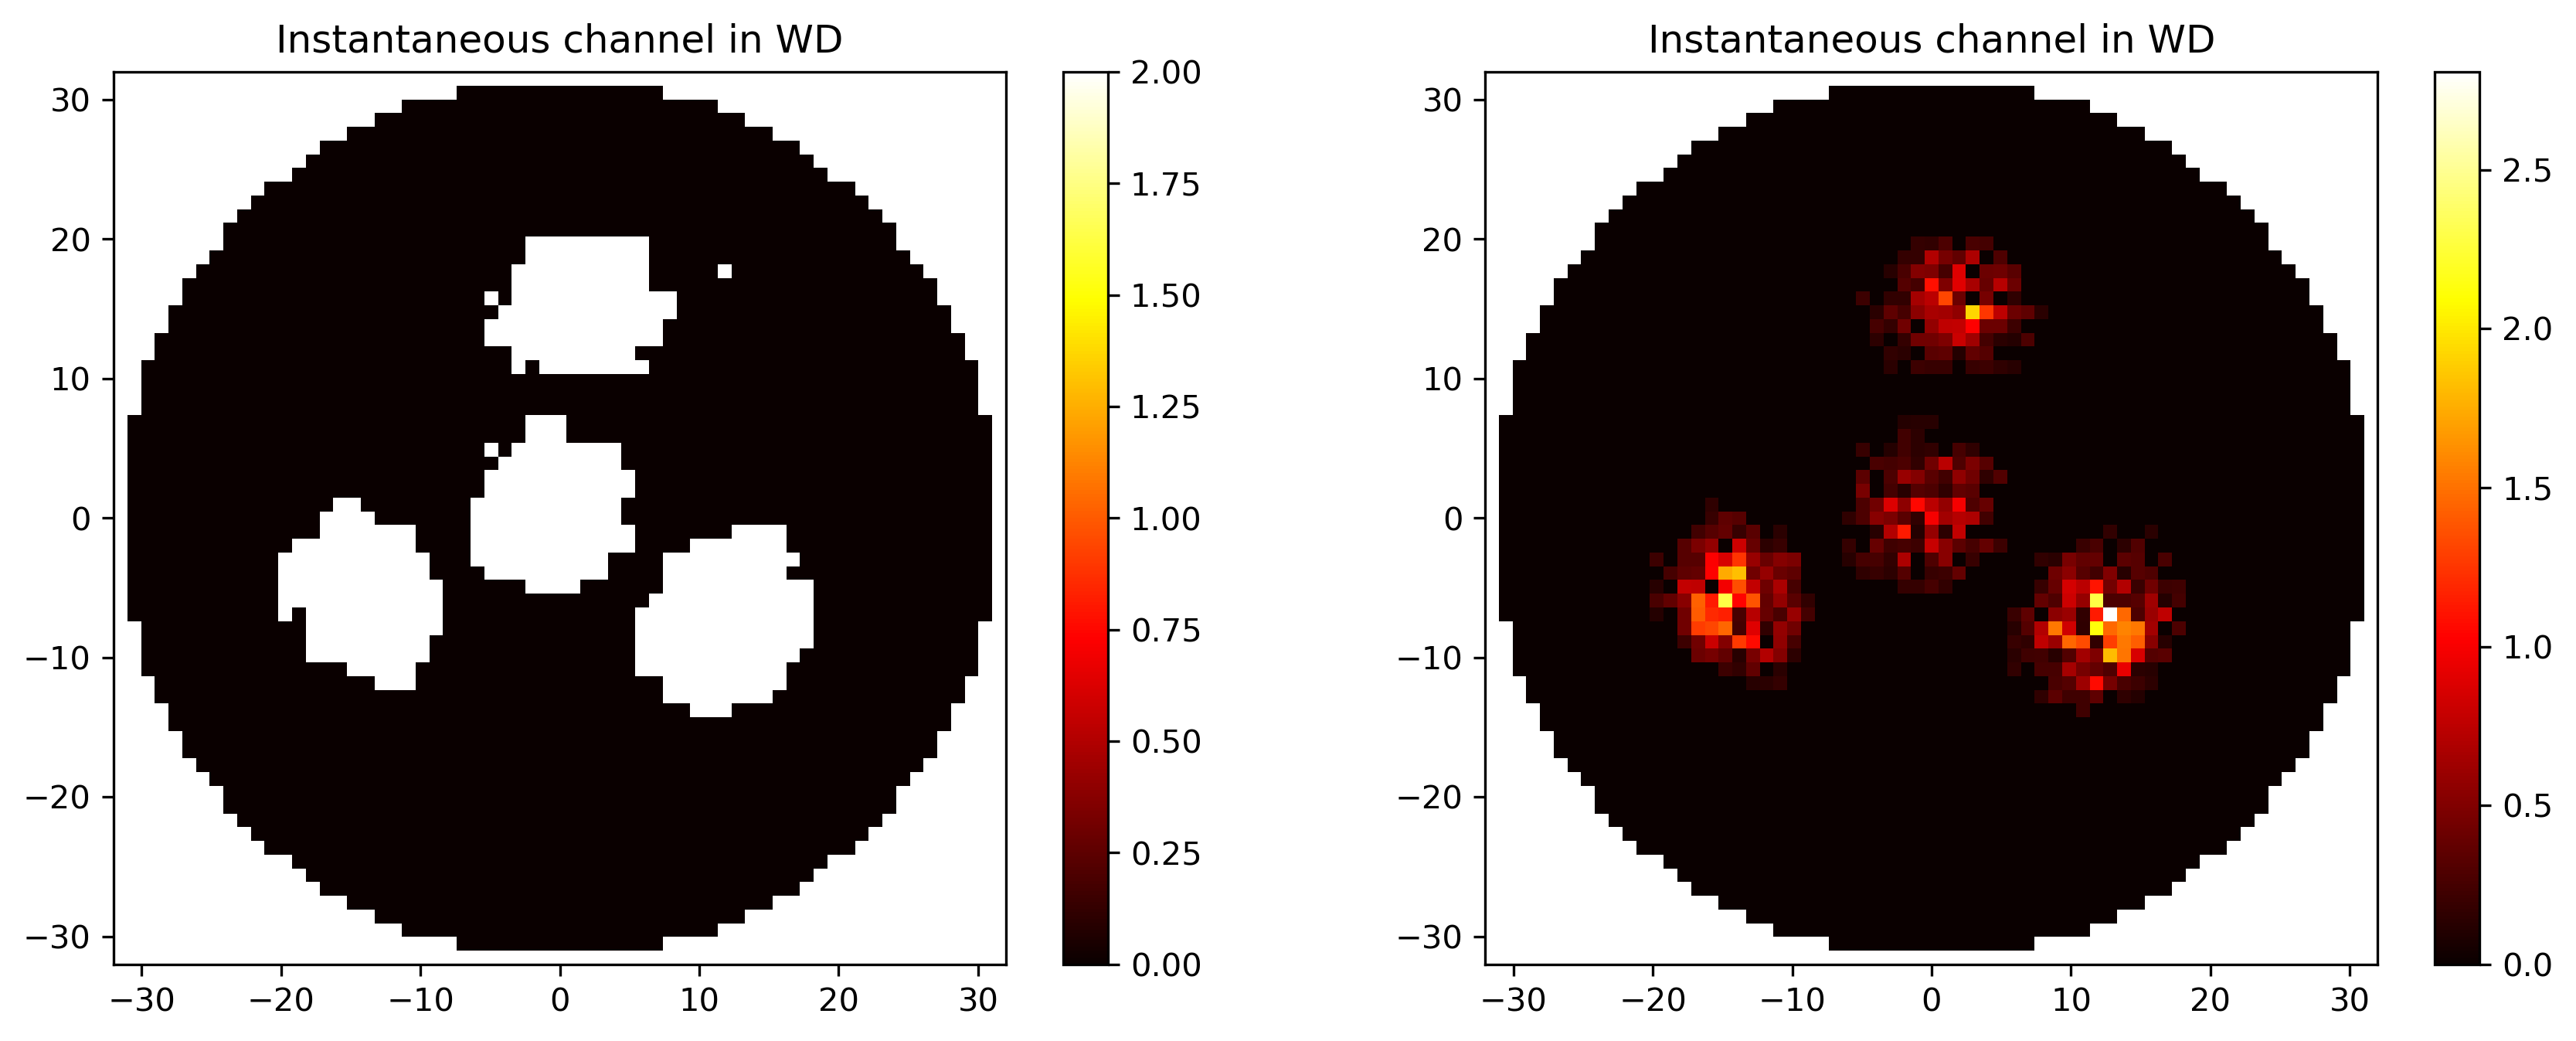

In [23]:
# Saving results
import os 
from scipy.io import savemat
# create folder if not exist
# folder = './data', with SNR and N_RF and spacing
spacing = int(lambda_c / delta)
folder = './data' + '/SNR_' + str(SNR) + '_Nx_' + str(N_x) + '_RF_' + str(N_RF) + '_spacing_' + str(spacing)
if not os.path.exists(folder):
    os.makedirs(folder)
test_visual(path=folder + "/RecoveryCompare.png")

#### Saving

/var/folders/n6/9zkr6zk96qz10ctnvn_mhc840000gn/T/ipykernel_32297/3182367393.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mat_H_a[l_x + l_x_abs_max, l_y + l_y_abs_max] = vec_H_a[l]


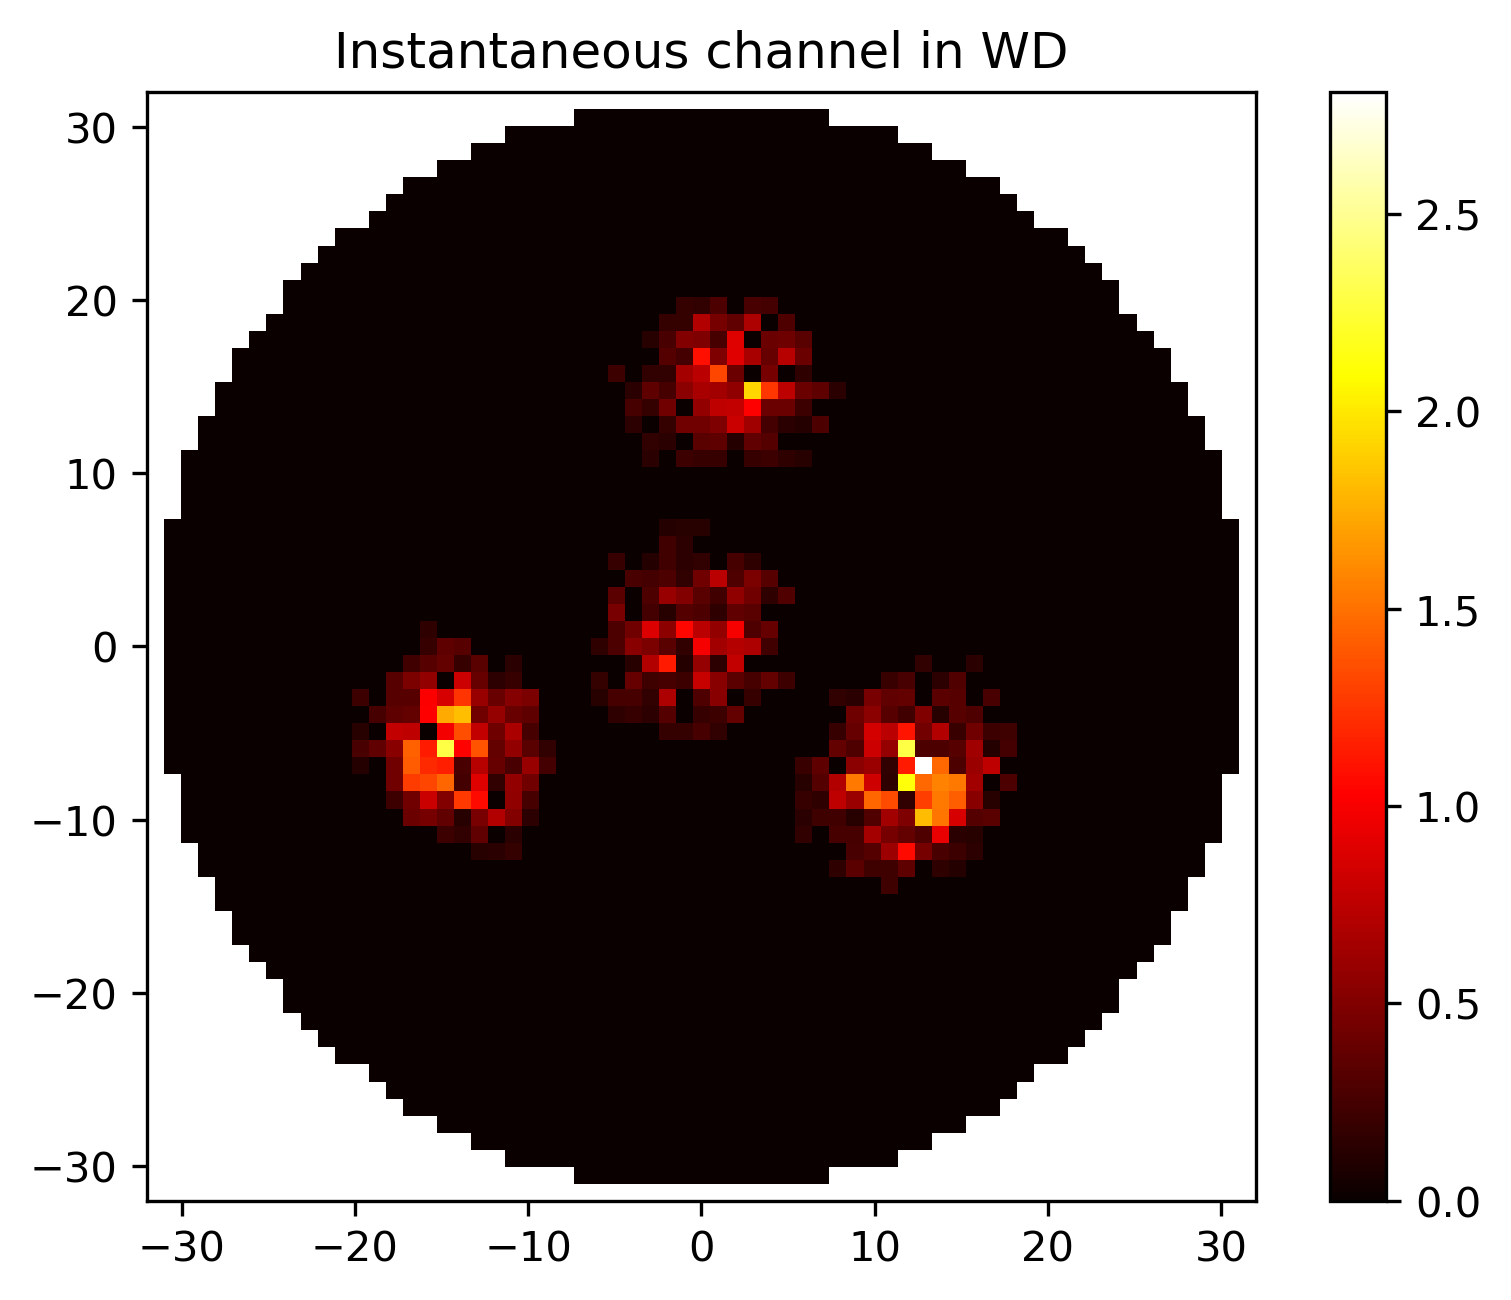

In [24]:




savemat(folder + '/alg_GCSE_WND.mat', {
    'NMSE_list_v2' : NMSE_list_v2,
    'NMSE_list' : NMSE_list,
    'vec_H_a_recovered' : visualize_wavenumber_domain_channel(test_EMRF.hat_h_sl),
    'meta_data' : {
        # 'cluster_para' : cluster_para,
        'f_c' : f_c,
        'N_x' : N_x,
        'N_y' : N_y,
        'lambda_c' : lambda_c,
        'delta' : delta,
        'N' : N,
        'N_RF' : N_RF,
        'L_x' : L_x,
        'L_y' : L_y,
        'K' : K,
        'sparseness' : sparseness,
        'sparse_power_threshold' : sparse_power_threshold,
        'eta' : eta,
        'xi' : xi,
        'l_x_abs_max' : l_x_abs_max,
        'l_y_abs_max' : l_y_abs_max,
        'M' : M,
        'SNR' : SNR,
        'iter_num' : iter_num
    },
}
)